# PyTorch: Variable, Gradientes e Grafo Computacional

## Objetivos

Este notebook introduz 
- o conceito de `Variables` do PyTorch,
- uma interpretação numérica intuitiva do gradiente, e o
- grafo computacional, utilizado para o cálculo automático do gradiente de uma função.

Um dos principais fundamentos para que o PyTorch seja adequado para deep learning é a sua habilidade de
calcular o gradiente automaticamente a partir da expressões definidas. Essa facilidade é implementada
pelo tipo Variable do PyTorch, que adiciona ao tensor a facilidade de cálculo automático do gradiente pela construção dinâmica do grafo computacional.

## Grafo computacional

```
    y_pred = x * w
    e = y_pred - y
    e2 = e**2
    J = e2.sum()
```

![alt text](https://raw.githubusercontent.com/vcasadei/images/master/GrafoComputacional.png)

Variable possui 3 campos: o dado em si (data), o gradiente (grad) e um apontador (creator) para construir o grafo da backpropagation. Uma expressão utilizada para o cálculo do gradiente exige que todas suas expressões sejam calculadas com Variables, caso contrário não é possível construir o grafo computacional.

![alt text](https://raw.githubusercontent.com/vcasadei/images/master/variables.png)

In [1]:
import torch
from torch.autograd import Variable

## Variable é criada a partir de um tensor e possui as mesmas funcionalidades

In [2]:
y_t = 2 * torch.arange(0.,4.)
y = Variable(y_t)
y

tensor([0., 2., 4., 6.])

In [3]:
x = Variable(torch.arange(0.,4.))
x

tensor([0., 1., 2., 3.])

In [4]:
w = Variable(torch.ones(1),requires_grad=True)
w

tensor([1.], requires_grad=True)

## Cálculo automático do gradiente da função perda J

Seja a expressão: $$ J = ((x  w) - y)^2 $$

Queremos calcular a derivada de $J$ em relação a $w$.

### Montagem do grafo computacional

In [5]:
# predict (forward)
y_pred = x * w

# cálculo da perda J: loss
e = y_pred - y
e2 = e.pow(2)
J = e2.sum()
J

tensor(14., grad_fn=<SumBackward0>)

## Auto grad - processa o grafo computacional backwards

O `backward()` varre o grafo computacional a partir da variável a ele associada e calcula o gradiente para todas as `Variables` que possuem o atributo `requires_grad` como verdadeiro.
O `backward()` destroi o grafo após sua execução. Isso é intrínsico ao PyTorch pelo fato dele ser uma rede dinâmica.

In [6]:
J.backward()
print(w.grad)

tensor([-28.])


In [7]:
lr = 0.01

In [8]:
w_new = w - lr * w.grad.data
w_new

tensor([1.2800], grad_fn=<SubBackward0>)

In [9]:
y_pred = x * w_new
J_new = ((y_pred - y).pow(2)).sum()
J_new

tensor(7.2576, grad_fn=<SumBackward0>)

## Interpretação do Gradiente

O gradiente de uma variável final (J) com respeito à outra variável de entrada (w) pode ser interpretado como o quanto a variável final J vai aumentar se houver um pequeno aumento na variável de entrada (w).
Por exemplo suponha que o gradiente seja 28. Isto significa se aumentarmos a variável w de 0.001, então J vai aumentar de 0.028.

In [10]:
eps = 0.001
y_pred = x * (w+eps)
J_new = (y_pred - y).pow(2).sum()
J_new

tensor(13.9720, grad_fn=<SumBackward0>)

In [11]:
print((J_new - J).data.numpy())

-0.027988434


## Back propagation

Uma forma equivalente explícita de calcular o gradiente é fazendo o processamento do backpropagation no grafo computacional, de forma explícita.
Apenas como ilustração.

In [12]:
import numpy as np

dJ = 1.
de2 = dJ * np.ones((4,))
de = de2 * 2 * e.data.numpy()
dy_pred = de
dw = (dy_pred * x.data.numpy()).sum()
print(dJ)
print(de2)
print(de)
print(dw)


1.0
[1. 1. 1. 1.]
[ 0. -2. -4. -6.]
-28.0


## Visualizando o grafo computacional

In [13]:
!pip install graphviz
!pip install git+https://github.com/szagoruyko/pytorchviz

  Cloning https://github.com/szagoruyko/pytorchviz to /tmp/pip-req-build-2bzqp_y2
  Running command git clone --filter=blob:none --quiet https://github.com/szagoruyko/pytorchviz /tmp/pip-req-build-2bzqp_y2
  Resolved https://github.com/szagoruyko/pytorchviz to commit 0adcd83af8aa7ab36d6afd139cabbd9df598edb7
  Preparing metadata (setup.py) ... - done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4990 sha256=71590063579ae273b14d554d56b47d9af987638dfbb90db87bb672636090243f
  Stored in directory: /tmp/pip-ephem-wheel-cache-m2lmib1w/wheels/2b/c4/0f/ca56745daf357286cad7d6a34ea87bb22986ae67d01fb35200
Successfully built torchviz


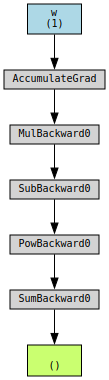

In [14]:
from torchviz import make_dot, make_dot_from_trace
J = ((w * x) - y).pow(2).sum()
p = {'w':w} # dicionário de parâmetros
out = make_dot(J,params=p)
out


# Exercícios

## Questões

1. Por que numa expressão computacional não é possível misturar `Variable` com tensores?
    1. Não é possível pois uma Variable adiciona informações adicionais aos tensores que permitem calcular o gradiente no grafo computacional.
2. O que acontece com o grafo computacional após execução do `backward()`?
    1. Quando ocorre o `backward()` as derivadas parciais de uma variável final em relação a `n` outras variáveis são calculadas.

## Atividades

1. Execute um passo de atualização do valor de w, pelo 
gradiente descendente. Utilize um fator de aprendizado (*learning rate*) de 0.1 
para atualizar o `w`. Após, recalcule a função de perda:

    - w = w - lr * w.grad.data
    - execute a célula 1.3.1 e verifique o quanto que a perda J diminuiu
    
2. No trecho abaixo, uma rede bastante conhecida, `resnet18` contendo 18 camadas 
   é criada, tendo
   como entrada `xin` que é convertida para `Variable`, resultando na saída `y`.
   
   Descomente a linha que cria a vizualização do grafo computacional e execute a
   célula para visualizar o grafo computacional da rede `resnet18`:

In [15]:
!pip install torchvision
from torchvision import models
xin = torch.randn(1,3,224,224)
resnet34 = models.resnet34()
y = resnet34(Variable(xin))

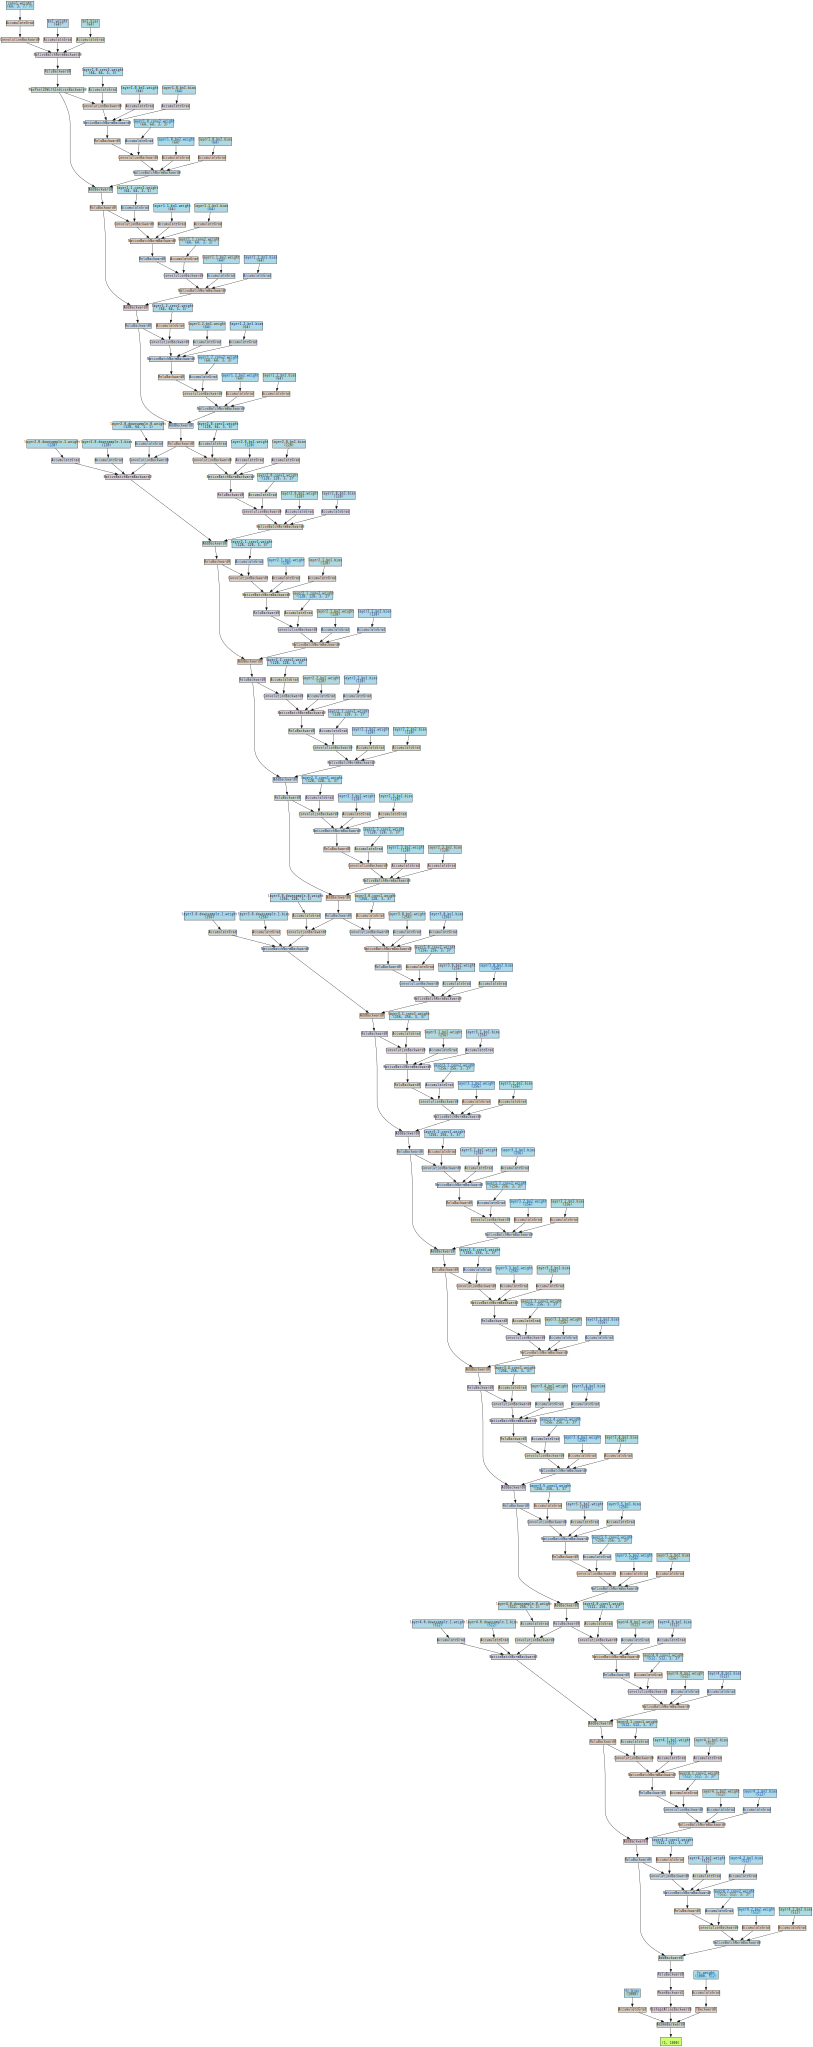

In [16]:
g = make_dot(y, dict(resnet34.named_parameters()))
g

# Aprendizados com este notebook

Uma das grandes vantagens do uso do PyTorch é utilizar Variables para calcular fácilmente os gradientes no grafo computacional. 